In [1]:
import os
import json
import pandas as pd
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load Data

In [3]:
DATASET = 'wsc-spacy'
wd = os.path.dirname(os.path.abspath('__file__'))
f_name = f"{DATASET}_RESULTS.csv"
hp_name = f"{DATASET}_HP_SPACE.json"
frame_count_name = f"{DATASET}_FRAMING_COUNTS.json"

results = pd.read_csv(os.path.join(wd, f_name))
hp_space = pd.read_json(os.path.join(wd, hp_name))

with open(frame_count_name) as f:
    frame_count = json.load(f)
    

In [4]:
print(list(results.columns.values))
print(f"\n {results.shape}")

framings = results['framing'].unique()
print(framings)

['Unnamed: 0', 'level_0', 'index', 'dataset', 'framing', 'learning_rate', 'batch_size', 'max_epochs', 'seed', 'best_val_accuracy', 'exp_name', 'best_iter', 'current_iter', 'total_iter', 'early_stop']

 (420, 15)
['MC-MLM' 'P-SPAN' 'MC-SENT' 'MC-SENT-PAIR' 'MC-SENT-PLOSS' 'P-SENT'
 'MC-SENT-SCALE']


In [5]:
print(results.shape[0])
print(len(results['exp_name'].unique()))
print(list(results['learning_rate'].unique()))
print(list(results['max_epochs'].unique()))
print(list(results['batch_size'].unique()))

420
420
[3e-05, 2e-05, 1e-05]
[40, 20, 10]
[8, 16, 32, 64]


In [6]:
print(hp_space)

   learning_rate  batch_size  max_epochs    dataset
0        0.00003           8          40  wsc-spacy
1        0.00002          16          20  wsc-spacy
2        0.00001          32          10  wsc-spacy
3        0.00000          64           0  wsc-spacy


# Analyze

In [7]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [98]:
def make_box_plots(data,
                   labels,
                   experiment_labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 15,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .85,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'peachpuff',
                             'burlywood',
                             'gold',
                             'lightgreen',
                             'skyblue',
                             'plum',
                             'darkgrey'
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                   majority = None,
                   human = None,
                   ylabel = 'Accuracy (%)',
                   xlabel = 'Formalization',
                   label_size = 18,
                   tick_size = 12,
                   plabel_size = 12,
                   bar = False,
                   label_type = 'max',
                   box = True,
                   violin = False,
                   titlepad=None,
                   titleh=None,
                  ):    
    scores = {
        'all'    : [],
        'max'    : [],
        '3Q'     : [],
        'median' : [],
    }
    
    add_x_offset = {
        'max'    : 0,
        '3Q'     : 0.4,
        'median' : 0.45,
    }
    
    add_y_offset = {
        'max'    : 0,
        '3Q'     : -y_offset,
        'median' : -y_offset,
    }  
        
    for label in experiment_labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        scores['all'].append(sorted(dist.to_numpy()))
        scores['max'].append(max(dist))
        scores['3Q'].append(dist.quantile(q=0.75))
        scores['median'].append(dist.median())
    
    n_samples = len(scores['all'][0])
    
    # add majority class
    if not majority is None:
        labels.insert(0,'Majority')
        if bar:
            scores['all'].insert(0,[0])
        else:
            scores['all'].insert(0,[majority]*n_samples)
        
        for key, item in scores.items():
            if key != 'all':
                item.insert(0,majority)
    
    # add human results
    if not human is None:
        labels.append('Human')
        if bar:
            scores['all'].append([0])
        else:
            scores['all'].append([human]*n_samples)

        for key, item in scores.items():
            if key != 'all':
                item.append(human)
    
    
    # create figure
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    # format chart
    if not title is None:
#         ax.set_title(title, fontsize=label_size, pad=titlepad)
        ax.text(len(labels)/2+0.5,
                titleh,
                title,
                fontsize=label_size,
                ha="center",
                )
    
    # format labels
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    ax.set_xticklabels(labels)
    ax.tick_params(labelsize=tick_size)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # make plots    
    assert label_type in scores.keys(), f"label_type {label_type} not supported"
    
    if bar:
        # bar chart
        if not bar_colors:
            colors = None
        ax.bar(ticks, scores[label_type], color = colors, alpha=bar_trans)
        
    if box:
        # box plot
        ax.boxplot(scores['all'], notch = notch, showfliers = showfliers)
        
    if violin:
        # violin plot
        ax.set_xticks(ticks)
        
        parts = ax.violinplot(scores['all'], positions = ticks, showmedians = False, showextrema=False, bw_method='silverman')
        
        if bar_colors:
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(.5)
                pc.set_edgecolor('black')

        quartile1, medians, quartile3 = np.percentile(scores['all'], [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(scores['all'], quartile1, quartile3)])
        whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

        inds = np.arange(1, len(medians) + 1)
        ax.scatter(inds[1:len(inds)-1], medians[1:len(inds)-1], marker='_', color='orange', s=1000, zorder=3)
        ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
        ax.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
                
    
    # add accuracy values
    for i, v in enumerate(scores[label_type]):
        if bar_labels or (i==0 or i==len(scores[label_type])-1):
            
            x=add_x_offset[label_type]
            y=add_y_offset[label_type]
            
            if ((not human is None and i == len(scores[label_type])-1)
                or (not majority is None and i == 0)):
                x = 0
                y = 0
                
            ax.text(i + x_offset + x,
                    v + y_offset + y,
                    "{:.1f}%".format(v),
                    fontsize=plabel_size,
                   )
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

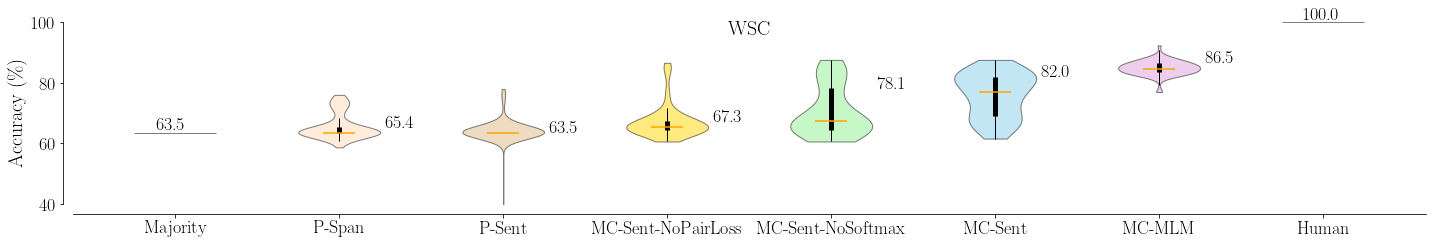

In [110]:
bar = False
box = False
violin = True

ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

chart_labels = ['P-Span',
               'P-Sent',
               'MC-Sent-NoPairLoss',
               'MC-Sent-NoSoftmax',
               'MC-Sent',
               'MC-MLM']

f_violin = make_box_plots(results,
                   chart_labels,
                   ordered_framings,
                   adjusted_axes = True,
                   title = 'WSC',
                   titleh=96,
                   showfliers = True,
                   x_size = 20,
                   y_size = 3.5,
                   y_min = 40,
                   y_max = 100,
                   y_tick = 20,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = None,
                   majority = 63.46153846153846,
                   human = 100.0,
                   label_size=20,
                   tick_size=18,
                   plabel_size=18,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

In [54]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
        value['max'] = max(dist)
        value['min'] = min(dist)
        value['top_3Q_dist'] = max(dist)-dist.quantile(q=0.75)
        value['kurtosis'] = dist.kurtosis()
    
    return results

In [55]:
ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

stats = get_stats(results,
                  ordered_framings,
                 )

print(stats)

{'P-SPAN': {'mean': 0.6560897435897436, 'std': 0.04130488475345711, 'medium': 0.6346153846153846, '1Q': 0.6346153846153846, '3Q': 0.6538461538461539, 'max': 0.7596153846153846, 'min': 0.5865384615384616, 'top_3Q_dist': 0.10576923076923073, 'kurtosis': 0.28236034424073564}, 'P-SENT': {'mean': 0.6397435897316667, 'std': 0.04570301690147087, 'medium': 0.6346153846, '1Q': 0.6346153846, '3Q': 0.6346153846, 'max': 0.7788461538, 'min': 0.3653846154, 'top_3Q_dist': 0.1442307692, 'kurtosis': 24.15578898418391}, 'MC-SENT-PLOSS': {'mean': 0.6729166666566666, 'std': 0.055377611281348584, 'medium': 0.6538461538, '1Q': 0.6442307692, '3Q': 0.6730769231, 'max': 0.8653846154000001, 'min': 0.6057692308, 'top_3Q_dist': 0.1923076923000001, 'kurtosis': 5.360475714706027}, 'MC-SENT-PAIR': {'mean': 0.7073717948783333, 'std': 0.08220854422519047, 'medium': 0.6730769231, '1Q': 0.6442307692, '3Q': 0.781249999975, 'max': 0.875, 'min': 0.6057692308, 'top_3Q_dist': 0.093750000025, 'kurtosis': -0.7931829542389299},

In [56]:
stats_df = pd.DataFrame(stats)

print(stats_df)

               P-SPAN     P-SENT  MC-SENT-PLOSS  MC-SENT-PAIR   MC-SENT  \
mean         0.656090   0.639744       0.672917      0.707372  0.758494   
std          0.041305   0.045703       0.055378      0.082209  0.072672   
medium       0.634615   0.634615       0.653846      0.673077  0.769231   
1Q           0.634615   0.634615       0.644231      0.644231  0.689904   
3Q           0.653846   0.634615       0.673077      0.781250  0.819712   
max          0.759615   0.778846       0.865385      0.875000  0.875000   
min          0.586538   0.365385       0.605769      0.605769  0.615385   
top_3Q_dist  0.105769   0.144231       0.192308      0.093750  0.055288   
kurtosis     0.282360  24.155789       5.360476     -0.793183 -1.185824   

               MC-MLM  
mean         0.848558  
std          0.024761  
medium       0.846154  
1Q           0.836538  
3Q           0.865385  
max          0.923077  
min          0.769231  
top_3Q_dist  0.057692  
kurtosis     2.957253  


# Save Stuff

In [111]:
wd = os.path.dirname(os.path.abspath('__file__'))
now = dt.now().strftime("%Y%m%d_%H%M")

f = f_violin
f_type = 'violin'

plot_name = os.path.join(wd, 'plots', f"{DATASET}_plot_{f_type}_{now}.pdf")
stats_name = os.path.join(wd, 'stats', f"{DATASET}_stats_{now}.json")

f.savefig(plot_name)
with open(stats_name, 'w') as f:
    f.write(json.dumps(stats))